# **Feature Engineering**

## Objectives

* Create new features to improve model predictions.
* Transform and combine existing features.
* Explore the relationships between features and the target variable.

## Inputs

* Cleaned dataset: `outputs/datasets/collection/HousePricesRecords.csv`
* Data with handled missing values and correct data types.

## Outputs

* New dataset with engineered features: `outputs/datasets/feature_engineered/HousePricesFeatures.csv`
* Visualizations (if applicable): Charts showing feature relationships and distributions.


___

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues'

___

## Load data

In [56]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

df = pd.read_csv("outputs/datasets/collection/HousePricesCleaned.csv")
print(df[['2ndFlrSF', 'BedroomAbvGr', 'SalePrice']].head())

   2ndFlrSF  BedroomAbvGr  SalePrice
0     854.0      3.000000   208500.0
1       0.0      3.000000   181500.0
2     866.0      3.000000   223500.0
3       0.0      2.869214   140000.0
4       0.0      4.000000   250000.0


In [57]:
# Define a custom encoder for categorical variables
class MyCustomEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, variables, mapping):
        self.variables = variables
        self.mapping = mapping

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for feature in self.variables:
            if feature in X.columns:
                X[feature] = X[feature].map(self.mapping.get(feature, {}))
        return X

# Mapping for categorical variables
mapping = {
    'BsmtExposure': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0},
    'BsmtFinType1': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0},
    'GarageFinish': {'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0},
    'KitchenQual': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0}
}

# Categorical and numerical columns
categorical_columns = ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']
numerical_columns = ['2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'GarageArea', 'GrLivArea']

In [58]:
print("Data types in X_numerical:")
print(X_numerical.dtypes)

print("Preview of X_numerical:")
print(X_numerical.head())


Data types in X_numerical:
2ndFlrSF        float64
BedroomAbvGr    float64
BsmtFinSF1      float64
GarageArea      float64
GrLivArea       float64
dtype: object
Preview of X_numerical:
   2ndFlrSF  BedroomAbvGr  BsmtFinSF1  GarageArea  GrLivArea
0     854.0      3.000000       706.0       548.0     1710.0
1       0.0      3.000000       978.0       460.0     1262.0
2     866.0      3.000000       486.0       608.0     1786.0
3       0.0      2.869214       216.0       642.0     1717.0
4       0.0      4.000000       655.0       836.0     2198.0


In [66]:
# Skala data först
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numerical)

# Skapa DataFrame av skalade data
X_scaled_df = pd.DataFrame(X_scaled, columns=numerical_columns)

# Applicera SmartCorrelatedSelection
corr_selector = SmartCorrelatedSelection(
    method="spearman",
    threshold=0.8,
    selection_method="variance"
)

try:
    # Få ut de transformera data och kolumnnamn
    X_corr_selected = corr_selector.fit_transform(X_scaled_df)
    # Skapa DataFrame från den returnerade arrayen
    X_corr_selected_df = pd.DataFrame(X_corr_selected, columns=X_scaled_df.columns[corr_selector.get_support()])

    print("Shape after correlation selection:", X_corr_selected_df.shape)
    print("Features kept:", X_corr_selected_df.columns.tolist())
except Exception as e:
    print("Error in SmartCorrelatedSelection:", e)


Shape after correlation selection: (1460, 5)
Features kept: ['2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'GarageArea', 'GrLivArea']


In [68]:
# Select only numerical features from the dataset
X_numerical = df[numerical_columns]

# Kontrollera datatyper och saknade värden innan pipeline
print("Data types in X_numerical:")
print(X_numerical.dtypes)
print("Missing values in X_numerical:")
print(X_numerical.isnull().sum())

# Skala data först
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numerical)

# Skapa DataFrame av skalade data
X_scaled_df = pd.DataFrame(X_scaled, columns=numerical_columns)

# Kontrollera de första raderna i de skalade data
print("Scaled data (first 5 rows):")
print(X_scaled_df.head())

# Testa pipelinen utan korrelationsurval
pipeline = Pipeline([
    ('scaler', StandardScaler())
])

try:
    # Apply pipeline
    X_transformed = pipeline.fit_transform(X_numerical)

    # Kontrollera om några features har tagits bort
    transformed_columns = numerical_columns

    print("Transformed columns:", transformed_columns)

    # Skapa DataFrame med transformerade data
    df_transformed = pd.DataFrame(X_transformed, columns=transformed_columns)
    df_transformed['SalePrice'] = df_cleaned['SalePrice']

    print("Transformed dataset size:", df_transformed.shape)
    print(df_transformed.head())
except Exception as e:
    print("Error during pipeline execution:", e)


Data types in X_numerical:
2ndFlrSF        float64
BedroomAbvGr    float64
BsmtFinSF1      float64
GarageArea      float64
GrLivArea       float64
dtype: object
Missing values in X_numerical:
2ndFlrSF        0
BedroomAbvGr    0
BsmtFinSF1      0
GarageArea      0
GrLivArea       0
dtype: int64
Scaled data (first 5 rows):
   2ndFlrSF  BedroomAbvGr  BsmtFinSF1  GarageArea  GrLivArea
0  1.213595      0.165232    0.575425    0.351000   0.370333
1 -0.756746      0.165232    1.171992   -0.060731  -0.482512
2  1.241281      0.165232    0.092907    0.631726   0.515013
3 -0.756746      0.000000   -0.499274    0.790804   0.383659
4 -0.756746      1.428607    0.463568    1.698485   1.299326
Transformed columns: ['2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'GarageArea', 'GrLivArea']
Transformed dataset size: (1460, 6)
   2ndFlrSF  BedroomAbvGr  BsmtFinSF1  GarageArea  GrLivArea  SalePrice
0  1.213595      0.165232    0.575425    0.351000   0.370333   208500.0
1 -0.756746      0.165232    1.171992   

In [69]:
df['2ndFlrSF'].fillna(0, inplace=True)

print("Missing values after filling:")
print(df.isnull().sum())

Missing values after filling:
1stFlrSF        0
2ndFlrSF        0
BedroomAbvGr    0
BsmtExposure    0
BsmtFinSF1      0
BsmtFinType1    0
BsmtUnfSF       0
GarageArea      0
GarageFinish    0
GarageYrBlt     0
GrLivArea       0
KitchenQual     0
LotArea         0
LotFrontage     0
MasVnrArea      0
OpenPorchSF     0
OverallCond     0
OverallQual     0
TotalBsmtSF     0
YearBuilt       0
YearRemodAdd    0
SalePrice       0
dtype: int64


Display summary statistics to understand the distribution of numerical features


In [70]:
df.describe()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtFinSF1,BsmtUnfSF,GarageArea,GarageYrBlt,GrLivArea,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,1162.626712,327.994521,2.869214,443.639726,567.240411,472.980137,1978.506164,1515.463699,10516.828082,70.049958,103.685262,46.660274,5.575342,6.099315,1057.429452,1971.267808,1984.865753,180921.195890
std,386.587738,433.576171,0.791802,456.098091,441.866955,213.804841,23.994583,525.480383,9981.264932,22.024023,180.569112,66.256028,1.112799,1.382997,438.705324,30.202904,20.645407,79442.502883
min,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1900.000000,334.000000,1300.000000,21.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1872.000000,1950.000000,34900.000000
25%,882.000000,0.000000,2.000000,0.000000,223.000000,334.500000,1962.000000,1129.500000,7553.500000,60.000000,0.000000,0.000000,5.000000,5.000000,795.750000,1954.000000,1967.000000,129975.000000
50%,1087.000000,0.000000,3.000000,383.500000,477.500000,480.000000,1978.506164,1464.000000,9478.500000,70.049958,0.000000,25.000000,5.000000,6.000000,991.500000,1973.000000,1994.000000,163000.000000
75%,1391.250000,714.500000,3.000000,712.250000,808.000000,576.000000,2001.000000,1776.750000,11601.500000,79.000000,164.250000,68.000000,6.000000,7.000000,1298.250000,2000.000000,2004.000000,214000.000000
max,4692.000000,2065.000000,8.000000,5644.000000,2336.000000,1418.000000,2010.000000,5642.000000,215245.000000,313.000000,1600.000000,547.000000,9.000000,10.000000,6110.000000,2010.000000,2010.000000,755000.000000


Visualize the distribution of 2ndFlrSF to see how many houses have a second floor and its size


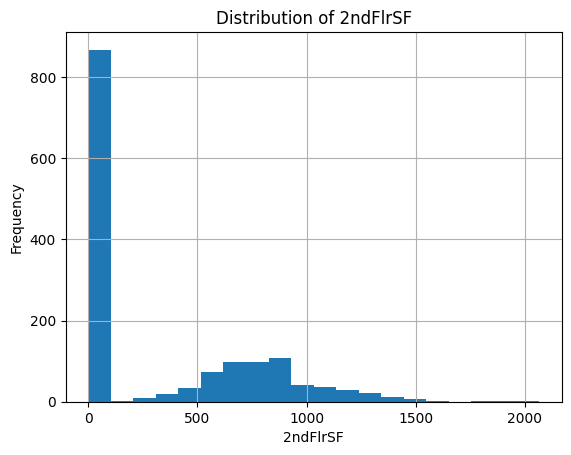

In [71]:
import matplotlib.pyplot as plt
df['2ndFlrSF'].hist(bins=20)
plt.title('Distribution of 2ndFlrSF')
plt.xlabel('2ndFlrSF')
plt.ylabel('Frequency')
plt.show()


In [73]:
print("Missing values in numerical columns:")
print(df_cleaned[numerical_columns].isnull().sum())


Missing values in numerical columns:
2ndFlrSF        0
BedroomAbvGr    0
BsmtFinSF1      0
GarageArea      0
GrLivArea       0
dtype: int64


In [74]:
print("DataFrame shape after operation:", df.shape)
print("DataFrame columns after operation:", df.columns.tolist())


DataFrame shape after operation: (1460, 22)
DataFrame columns after operation: ['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinType1', 'BsmtUnfSF', 'GarageArea', 'GarageFinish', 'GarageYrBlt', 'GrLivArea', 'KitchenQual', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'TotalBsmtSF', 'YearBuilt', 'YearRemodAdd', 'SalePrice']


Show correlation matrix for numeric features

In [75]:
correlation_matrix = df.select_dtypes(include=['float64', 'int64']).corr()


Create a heatmap to visualize the correlation matrix

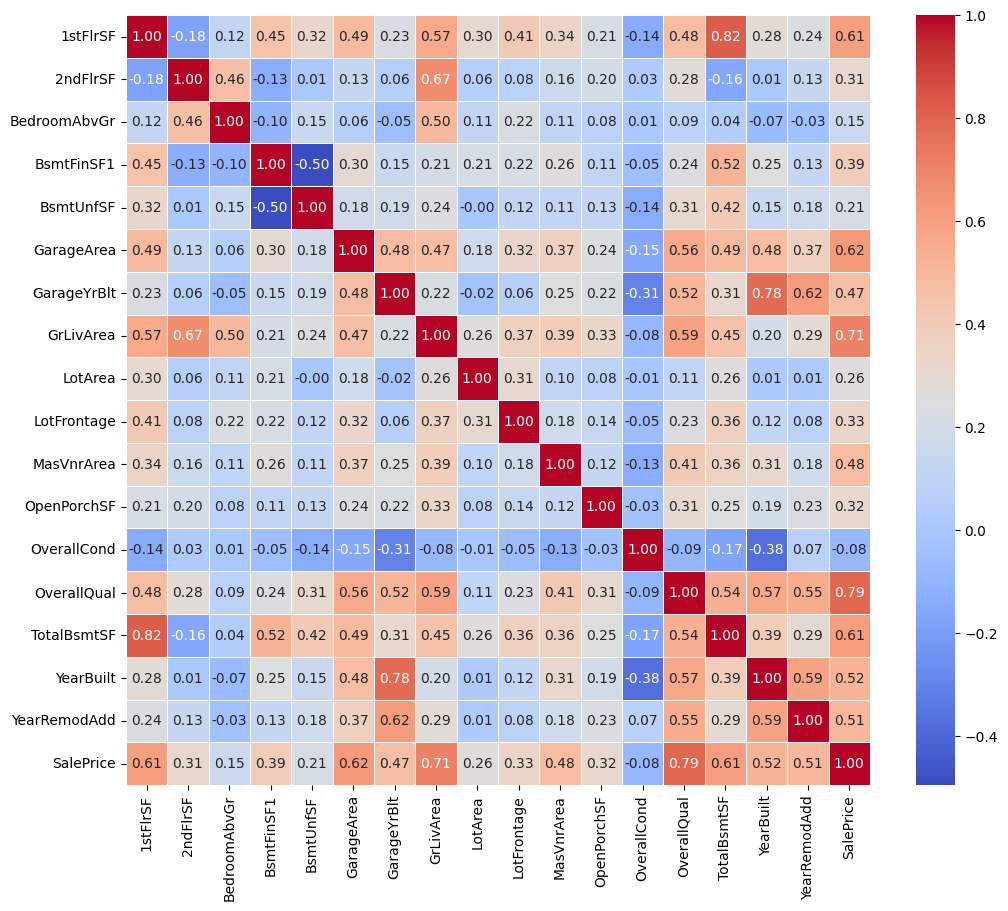

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.show()


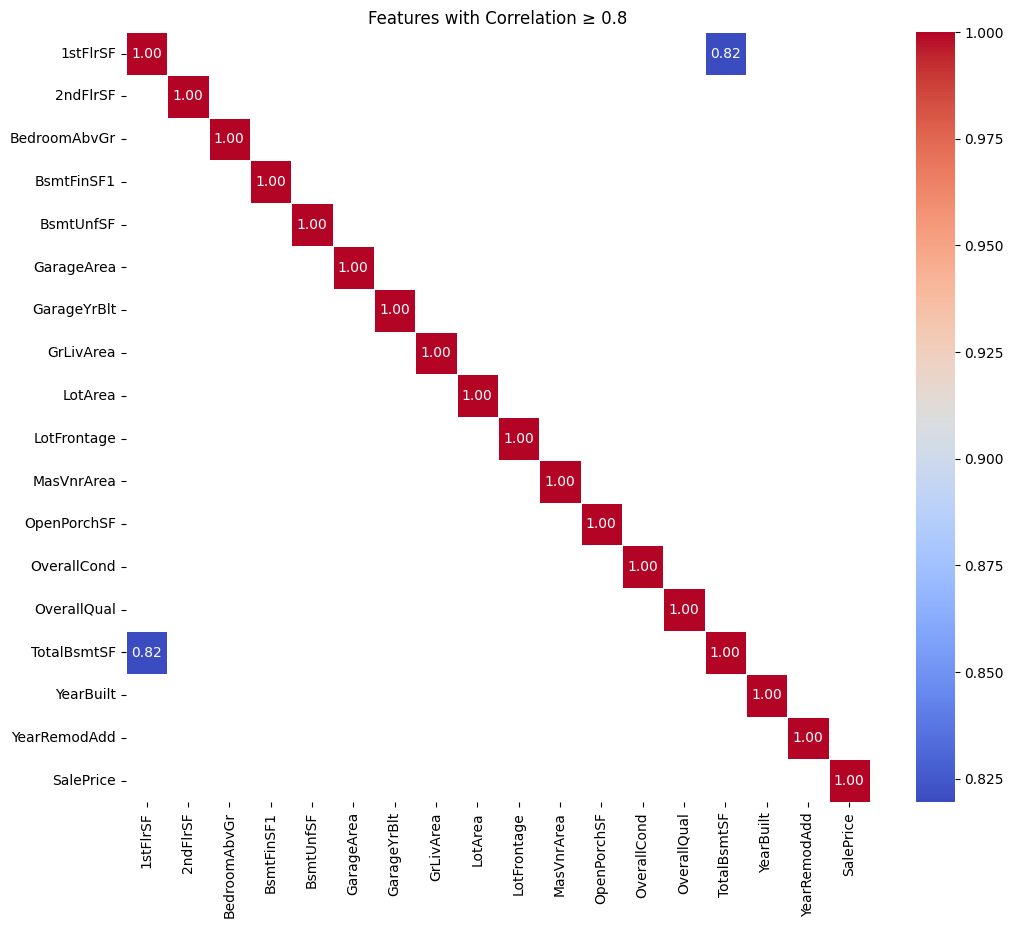

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Threshold for high correlation
threshold = 0.8

# Filter correlation matrix to keep values >= 0.8
high_correlation = correlation_matrix.applymap(lambda x: x if x >= threshold else np.nan)

# Plot the filtered correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(high_correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar=True)
plt.title("Features with Correlation ≥ 0.8")
plt.show()


Show datatypes

In [78]:
print(df.dtypes)


1stFlrSF        float64
2ndFlrSF        float64
BedroomAbvGr    float64
BsmtExposure     object
BsmtFinSF1      float64
BsmtFinType1     object
BsmtUnfSF       float64
GarageArea      float64
GarageFinish     object
GarageYrBlt     float64
GrLivArea       float64
KitchenQual      object
LotArea         float64
LotFrontage     float64
MasVnrArea      float64
OpenPorchSF     float64
OverallCond       int64
OverallQual       int64
TotalBsmtSF     float64
YearBuilt         int64
YearRemodAdd      int64
SalePrice       float64
dtype: object


Print the number of unique values in each column

In [84]:
print(df.nunique())
print(df['SalePrice'].unique())


1stFlrSF         753
2ndFlrSF         401
BedroomAbvGr       9
BsmtExposure       4
BsmtFinSF1       637
BsmtFinType1       6
BsmtUnfSF        780
GarageArea       441
GarageFinish       3
GarageYrBlt       98
GrLivArea        861
KitchenQual        4
LotArea         1073
LotFrontage      111
MasVnrArea       328
OpenPorchSF      202
OverallCond        9
OverallQual       10
TotalBsmtSF      721
YearBuilt        112
YearRemodAdd      61
SalePrice        663
dtype: int64
[208500. 181500. 223500. 140000. 250000. 143000. 307000. 200000. 129900.
 118000. 129500. 345000. 144000. 279500. 157000. 132000. 149000.  90000.
 159000. 139000. 325300. 139400. 230000. 154000. 256300. 134800. 306000.
 207500.  68500.  40000. 149350. 179900. 165500. 277500. 309000. 145000.
 153000. 109000.  82000. 160000. 170000. 130250. 141000. 319900. 239686.
 249700. 113000. 127000. 177000. 114500. 110000. 385000. 130000. 180500.
 172500. 196500. 438780. 124900. 158000. 101000. 202500. 219500. 317000.
 180000. 22600

Split data into training and test sets (70% training, 30% test)

In [85]:
from sklearn.model_selection import train_test_split

X = df.drop('SalePrice', axis=1)
y = df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")


Training set: (1022, 21), Test set: (438, 21)


___

In [86]:
print(df_transformed.head())
print(df_transformed.info())


   2ndFlrSF  BedroomAbvGr  BsmtFinSF1  GarageArea  GrLivArea  SalePrice
0       0.0           0.0         0.0         0.0        0.0   208500.0
1       0.0           0.0         0.0         0.0        0.0   181500.0
2       0.0           0.0         0.0         0.0        0.0   223500.0
3       0.0           0.0         0.0         0.0        0.0   140000.0
4       0.0           0.0         0.0         0.0        0.0   250000.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   2ndFlrSF      1460 non-null   float64
 1   BedroomAbvGr  1460 non-null   float64
 2   BsmtFinSF1    1460 non-null   float64
 3   GarageArea    1460 non-null   float64
 4   GrLivArea     1460 non-null   float64
 5   SalePrice     1460 non-null   float64
dtypes: float64(6)
memory usage: 68.6 KB
None


## Push files to repo

In [87]:
print("Missing values after pipeline:")
print(df_transformed.isnull().sum())

df_transformed.to_csv("../jupyter_notebooks/outputs/datasets/collection/HousePricesFeatures.csv", index=False)
print("Exported the transformed dataset successfully!")


Missing values after pipeline:
2ndFlrSF        0
BedroomAbvGr    0
BsmtFinSF1      0
GarageArea      0
GrLivArea       0
SalePrice       0
dtype: int64
Exported the transformed dataset successfully!
